<a href="https://colab.research.google.com/github/Keerthibalraj/Deep-learning-technique-for-detection-of-Pneumonia-using-Chest-X-Ray-Images/blob/main/Pneumonia_Normal_detection_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [2]:
!pip install tqdm
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

{"username":"---","key":"---"}

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/chest-xray-pneumonia/chest_xray/chest_xray/train'
valid_path = '/content/chest-xray-pneumonia/chest_xray/chest_xray/test'

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  # useful for getting number of classes
folders = glob('/content/chest-xray-pneumonia/chest_xray/chest_xray/train/*')


# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [6]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/chest-xray-pneumonia/chest_xray/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/chest-xray-pneumonia/chest_xray/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


<ipython-input-8-39a22121036e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
163/163 [==============================] - 97s 564ms/step - loss: 0.1823 - accuracy: 0.9317 - val_loss: 0.2860 - val_accuracy: 0.9087
Epoch 2/5
163/163 [==============================] - 88s 541ms/step - loss: 0.1101 - accuracy: 0.9601 - val_loss: 0.2212 - val_accuracy: 0.9215
Epoch 3/5
163/163 [==============================] - 86s 527ms/step - loss: 0.1006 - accuracy: 0.9663 - val_loss: 0.2182 - val_accuracy: 0.9295
Epoch 4/5
163/163 [==============================] - 87s 534ms/step - loss: 0.0888 - accuracy: 0.9657 - val_loss: 0.8482 - val_accuracy: 0.7532
Epoch 5/5
163/163 [==============================] - 86s 529ms/step - loss: 0.1075 - accuracy: 0.9618 - val_loss: 0.4521 - val_accuracy: 0.8958


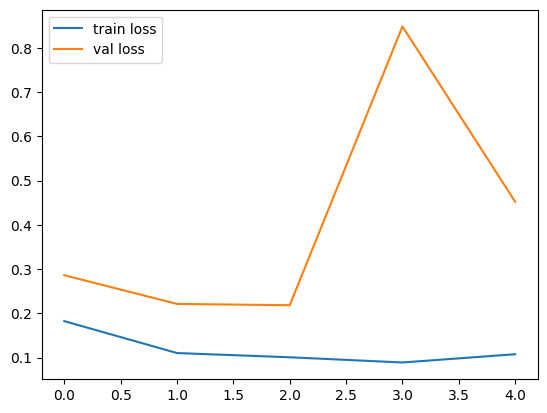

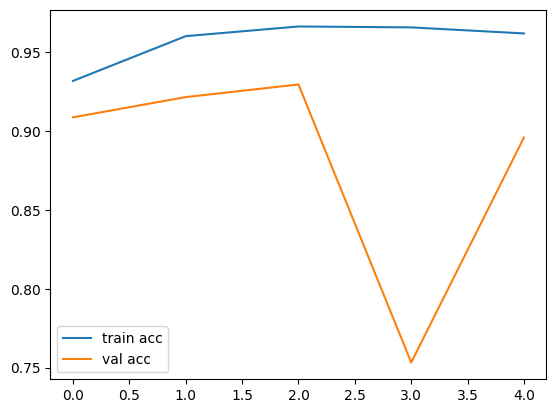

<Figure size 640x480 with 0 Axes>

In [10]:
 #loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Val_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Val_acc')

In [11]:
import tensorflow as tf

from keras.models import load_model

model.save('model_vgg16.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing our model

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('model_vgg16.h5')
img = image.load_img('/content/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
